## Problem 36: The Lindblad Master Equation (Qubit Decay)

**Physics:**  
Perfectly isolated quantum systems are an idealization. In reality, qubits lose energy to their environment through processes such as spontaneous emission. This open-system dynamics is described by the **Lindblad master equation**:

$\dot{\rho} = -i[H, \rho] + \sum_i \mathcal{D}[C_i]\rho$

where the Lindblad dissipator is defined as

$\mathcal{D}[C]\rho = C\rho C^\dagger - \frac{1}{2}\{C^\dagger C, \rho\}$.

This formalism guarantees completely positive, trace-preserving evolution of the density matrix.

---

**System:** Single qubit.

---

**Tasks:**

1. **Initial State:**  
   Prepare the qubit in the excited state $|1\rangle$.

2. **Decay Channel:**  
   Define a collapse (decay) operator  
   $C = \sqrt{\gamma}\,\sigma_-$  
   with decay rate $\gamma = 0.1$.

3. **Time Evolution:**  
   Evolve the system for times  
   $t \in [0, 50]$  
   using `mesolve`.

4. **Measurement:**  
   Track the excited-state population  
   $P_1(t) = \langle |1\rangle\langle 1| \rangle$.

---

**Expected Physics Check:**

- The excited-state population decays **exponentially** in time.
- The decay rate is set by $\gamma$.
- In the long-time limit, the system relaxes to the ground state $|0\rangle$.
- This behavior illustrates **energy relaxation** (T₁ decay) of a qubit.

This model provides the simplest and most important example of open quantum system dynamics.


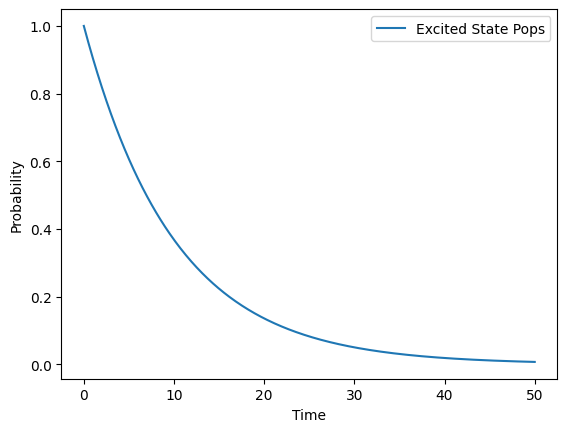

In [21]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

psi = basis(2,0)
gamma = 0.1
c_ops = [np.sqrt(gamma)*sigmam()]
H = 0*sigmaz()
e_ops = [psi*psi.dag()]
times = np.linspace(0,50,500)
results = mesolve(H,psi,times,c_ops,e_ops)
plt.plot(times,results.expect[0],label = "Excited State Pops")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.legend()
plt.show()

## Problem 37: Dephasing vs. Relaxation

**Physics:**  
In realistic quantum systems (such as superconducting qubits), decoherence arises from **multiple independent noise channels**.

- **Relaxation (T₁):**  
  Energy loss to the environment, described by the lowering operator $\sigma_-$.

- **Dephasing (T$_\phi$):**  
  Loss of phase coherence without energy exchange, described by $\sigma_z$.

While relaxation drives the system toward the ground state, dephasing destroys quantum superpositions by suppressing off-diagonal density-matrix elements.

---

**System:** Single qubit (open quantum system).

---

**Tasks:**

1. **Initial State:**  
   Prepare the superposition state  
   $|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$.

2. **Collapse Operators:**  
   Define two independent decoherence channels:
   - Relaxation: $C_{\text{relax}} = \sqrt{0.05}\,\sigma_-$  
   - Dephasing: $C_{\text{deph}} = \sqrt{0.1}\,\sigma_z$

3. **Time Evolution:**  
   Evolve the system using the Lindblad master equation with both collapse operators active.

4. **Observables:**  
   Track:
   - $\langle \sigma_x \rangle$ — coherence of the superposition
   - Purity $\text{Tr}(\rho^2)$ — degree of mixedness of the quantum state

---

**Expected Physics Check:**

- $\langle \sigma_x \rangle$ decays due to **both** relaxation and dephasing.
- Pure dephasing suppresses coherence **without changing populations**.
- Relaxation drives the system toward the ground state.
- The purity decreases from 1 as the state becomes mixed.
- Dephasing alone preserves populations but reduces purity.

This problem clearly distinguishes **loss of energy** from **loss of phase coherence**, a central concept in open quantum systems.


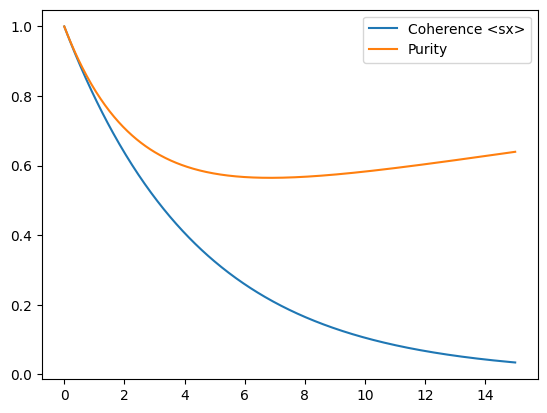

In [34]:
c_r = np.sqrt(0.05)*sigmam()
c_d = np.sqrt(0.1)*sigmaz()
psi = (basis(2,0)+basis(2,1)).unit()
c_ops = [c_r,c_d]
H = 0*sigmax()
times = np.linspace(0,15,500)
e_ops = [sigmax()]
rho = ket2dm(psi)
results = mesolve(H, psi, times,c_ops,e_ops)
purity = [(rho*rho).tr() for rho in mesolve(H, psi, times,c_ops,[]).states]
plt.plot(times, results.expect[0], label="Coherence <sx>")
plt.plot(times, purity, label="Purity")
plt.legend(); plt.show()

The coherence ⟨σx⟩ decays monotonically due to both relaxation and dephasing, reflecting the loss of phase coherence in the superposition state. The purity initially decreases as the state becomes mixed, but later increases as relaxation drives the system toward the ground state, which is pure. The presence of dephasing prevents full purification, resulting in a partial recovery of purity. This behavior highlights the competing roles of relaxation and dephasing in open quantum systems.


## Problem 38: Driven–Dissipative Harmonic Oscillator

**Physics:**  
When a harmonic oscillator is coherently driven while simultaneously losing energy to its environment, it does not heat indefinitely. Instead, the competition between driving and damping leads to a **non-equilibrium steady state**.

This type of driven–dissipative dynamics is central to cavity QED, circuit QED, optomechanics, and magnonics.

---

**System:** Single harmonic oscillator.

---

**Model:**

- **Hilbert Space:**  
  Finite oscillator space with cutoff $N = 20$.

- **Hamiltonian (Coherent Drive):**  
  $H = \eta (a + a^\dagger)$  
  with drive strength $\eta = 0.5$.

- **Dissipation (Photon Loss):**  
  Collapse operator  
  $C = \sqrt{\kappa}\, a$  
  with damping rate $\kappa = 0.2$.

---

**Tasks:**

1. **Initial State:**  
   Prepare the oscillator in the vacuum state $|0\rangle$.

2. **Time Evolution:**  
   Evolve the system using the Lindblad master equation until it reaches a steady state.

3. **Observable:**  
   Track the mean occupation number  
   $\langle n \rangle = \langle a^\dagger a \rangle$  
   as a function of time.

4. **Steady-State Verification:**  
   Verify that the long-time population approaches the analytical value  
   $n_{\text{ss}} = (2\eta / \kappa)^2$.

---

**Expected Physics Check:**

- The oscillator population increases from zero due to the coherent drive.
- Dissipation prevents unbounded growth and stabilizes the system.
- The population saturates at a steady-state value.
- The numerical steady-state occupation agrees with  
  $n_{\text{ss}} = (2\eta / \kappa)^2$.

This problem illustrates how non-equilibrium steady states arise naturally in open quantum systems.


Running active phase sweep...


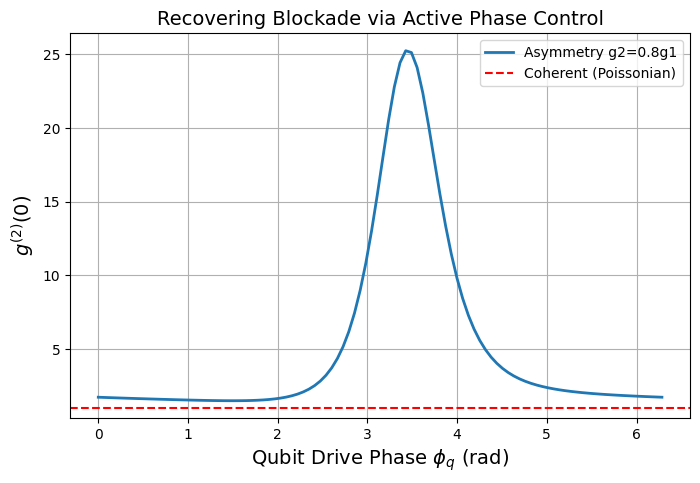

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# --- 1. System Parameters (Asymmetric) ---
N = 3              # Truncation levels (0, 1, 2)
g1 = 1.0           # Coupling YIG 1 (Reference)
g2 = 0.8 * g1      # <--- ASYMMETRY (20% Defect)
g_q = 1.0          # Qubit coupling
J = 0.1            # Magnon-Magnon coupling

# Frequencies & Decay
delta_m = 0.0      # Detuning
kappa = 0.05       # YIG Decay
gamma = 0.05       # Qubit Decay

# Driving (The Active Control)
eta = 0.005        # Weak magnon drive
Omega = 0.005      # Qubit drive strength (adjustable)

# --- 2. Operators ---
a1 = tensor(destroy(N), qeye(N), qeye(2)) # YIG 1
a2 = tensor(qeye(N), destroy(N), qeye(2)) # YIG 2
sm = tensor(qeye(N), qeye(N), sigmam())   # Qubit

# --- 3. The Simulation Loop (Phase Sweep) ---
phi_q_list = np.linspace(0, 2*np.pi, 100)
g2_results = []

print("Running active phase sweep...")

for phi in phi_q_list:
    # A. Hamiltonian (In Rotating Frame)
    # Free Energy
    H0 = delta_m * (a1.dag() * a1 + a2.dag() * a2) + delta_m * sm.dag() * sm
    
    # Interaction (Asymmetric g1 != g2)
    H_int = g1 * (a1.dag() * sm + a1 * sm.dag()) + \
            g2 * (a2.dag() * sm + a2 * sm.dag()) + \
            J * (a1.dag() * a2 + a1 * a2.dag())

    # Active Driving (The Innovation)
    # Note: Omega depends on phi
    H_drive = eta * (a1.dag() + a1) + \
              eta * (a2.dag() + a2) + \
              Omega * (sm.dag() * np.exp(-1j * phi) + sm * np.exp(1j * phi))

    H = H0 + H_int + H_drive

    # B. Collapse Operators (Dissipation)
    c_ops = [np.sqrt(kappa) * a1, np.sqrt(kappa) * a2, np.sqrt(gamma) * sm]

    # C. Solve Steady State
    rho_ss = steadystate(H, c_ops)

    # D. Calculate Correlation g(2)(0) for YIG 1
    # g2 = <a+ a+ a a> / <a+ a>^2
    num = expect(a1.dag() * a1.dag() * a1 * a1, rho_ss)
    den = expect(a1.dag() * a1, rho_ss) ** 2
    g2_results.append(num / den)

# --- 4. Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(phi_q_list, g2_results, label=f'Asymmetry g2={g2/g1:.1f}g1', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', label='Coherent (Poissonian)')
plt.xlabel(r'Qubit Drive Phase $\phi_q$ (rad)', fontsize=14)
plt.ylabel(r'$g^{(2)}(0)$', fontsize=14)
plt.title('Recovering Blockade via Active Phase Control', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()